# Worksheet 10.1 Shooting Method for Boundary Value Problems
## ENGR 240: Engineering Computations

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/WCC-Engineering/ENGR240/blob/main/Class%20Demos%20and%20Activities/Week%2010/Worksheet%2010-1%20Shooting%20Method%20CPU%20Heat%20Sink.ipynb)

## Introduction: CPU Heat Sink Fin Analysis

Modern CPUs generate significant heat and require efficient cooling to prevent thermal damage. Heat sink fins are critical components that extend the surface area for heat dissipation. In this worksheet, we'll analyze the temperature distribution along a single aluminum fin using the **shooting method** for boundary value problems.

### Physical System

**Heat Sink Fin Specifications:**
- **Material**: Aluminum (k = 205 W/m·K)
- **Length**: 50 mm (0.05 m)
- **Cross-section**: Rectangular, 2mm × 10mm
- **Base temperature**: 80°C (constant, maintained by heat sink base)
- **Ambient temperature**: 25°C
- **Heat generation**: Internal heating from adjacent fins and electrical resistance

### Mathematical Model

The steady-state heat equation with internal heat generation:
$$\frac{d^2T}{dx^2} + \frac{q}{k} = 0$$

**Boundary Conditions:**
- **Base (x = 0)**: Fixed temperature $T(0) = 80°C$
- **Tip (x = L)**: Convective cooling $-k\frac{dT}{dx}\bigg|_{x=L} = h(T_L - T_{amb})$

**Learning Objectives:**
- Implement shooting method for linear BVPs (use linear interpolation)
- Implement shooting method for nonlinear BVPs (formulate as roots problem)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [12, 8]
print("Libraries imported successfully!")

## System Parameters

In [7]:
# Physical parameters
L = 0.05          # Fin length (m)
k = 205           # Thermal conductivity of aluminum (W/m·K)
h = 80            # Convection coefficient (W/m²·K)
q_gen = 2e3       # Internal heat generation (W/m³)
T_base = 80       # Base temperature (°C)
T_amb = 25        # Ambient temperature (°C)

# Display parameters
print("=== CPU Heat Sink Fin Parameters ===")
print(f"Length: {L*1000:.0f} mm")
print(f"Material: Aluminum (k = {k} W/m·K)")
print(f"Base temperature: {T_base}°C")
print(f"Ambient temperature: {T_amb}°C")
print(f"Convection coefficient: {h} W/m²·K")
print(f"Internal heat generation: {q_gen/1e6:.1f} MW/m³")

=== CPU Heat Sink Fin Parameters ===
Length: 50 mm
Material: Aluminum (k = 205 W/m·K)
Base temperature: 80°C
Ambient temperature: 25°C
Convection coefficient: 80 W/m²·K
Internal heat generation: 0.0 MW/m³


## Task 1: Converting BVP to System of First-Order ODEs

The second-order BVP must be converted to a system of first-order ODEs for numerical solution.

**Original equation**: $\frac{d^2T}{dx^2} + \frac{q}{k} = 0$

**Define state variables:**
- $y_1 = T$ (temperature)
- $y_2 = \frac{dT}{dx}$ (temperature gradient)

**First-order system:**
- $\frac{dy_1}{dx} = y_2$
- $\frac{dy_2}{dx} = -\frac{q}{k}$

In [8]:
def heat_fin_ode(x, y):
    """
    Heat transfer ODE system for CPU fin.

    Args:
        x: Position along fin (m)
        y: State vector [T, dT/dx]

    Returns:
        dydt: Derivatives [dT/dx, d²T/dx²]
    """
    T, dT_dx = y[0], y[1]

    # First-order system
    dT_dx1 = dT_dx                    # dy1/dx = y2
    d2T_dx2 = -q_gen / k            # dy2/dx = -q/k

    return [dT_dx1, d2T_dx2]

# Test the ODE function
test_y = [60, -100]  # Test state: T=60°C, dT/dx=-100 K/m
test_derivs = heat_fin_ode(0.01, test_y)
print(f"Test derivatives: {test_derivs}")
print(f"dT/dx = {test_derivs[0]} K/m")
print(f"d²T/dx² = {test_derivs[1]} K/m²")

Test derivatives: [-100, -9.75609756097561]
dT/dx = -100 K/m
d²T/dx² = -9.75609756097561 K/m²


## Task 2: Understanding the Boundary Value Problem

Before implementing the shooting method, let's see what happens when we try to solve this as a simple IVP with different guesses for the initial slope.

In [9]:
# Function to calculate the boundary condition error at x = L
def convective_bc_error(T_L, dT_dx_L):
    """
    Calculate the error in the convective boundary condition.

    Boundary condition: -k * dT/dx|_L = h * (T_L - T_amb)
    Error = actual_flux - required_flux
    """
    actual_flux = -k * dT_dx_L
    required_flux = h * (T_L - T_amb)
    return actual_flux - required_flux

# Try several different initial slopes
initial_slopes = [400, 200, -200, -400, -800, -1000]  # Initial guesses for dT/dx at x=0
x_span = (0, L)
x_eval = np.linspace(0, L, 100)

print("=== Exploring Different Initial Slopes ===")
solutions = []

for slope in initial_slopes:
    # Initial conditions: T(0) = T_base, dT/dx(0) = slope
    y0 = [T_base, slope]

    # Solve the IVP
    sol = solve_ivp(heat_fin_ode, x_span, y0, t_eval=x_eval, method='RK45')

    # Check boundary condition at tip
    T_tip = sol.y[0, -1]
    dT_dx_tip = sol.y[1, -1]
    bc_error = convective_bc_error(T_tip, dT_dx_tip)

    solutions.append({
        'slope': slope,
        'x': sol.t,
        'T': sol.y[0],
        'dT_dx': sol.y[1],
        'T_tip': T_tip,
        'bc_error': bc_error
    })

    print(f"Initial slope: {slope:5.0f} K/m → Tip temp: {T_tip:5.1f}°C, BC error: {bc_error:8.1f} W/m²")

print(f"\nTarget: Find the slope that makes BC error ≈ 0")

=== Exploring Different Initial Slopes ===
Initial slope:   400 K/m → Tip temp: 100.0°C, BC error: -87899.0 W/m²
Initial slope:   200 K/m → Tip temp:  90.0°C, BC error: -46099.0 W/m²
Initial slope:  -200 K/m → Tip temp:  70.0°C, BC error:  37501.0 W/m²
Initial slope:  -400 K/m → Tip temp:  60.0°C, BC error:  79301.0 W/m²
Initial slope:  -800 K/m → Tip temp:  40.0°C, BC error: 162901.0 W/m²
Initial slope: -1000 K/m → Tip temp:  30.0°C, BC error: 204701.0 W/m²

Target: Find the slope that makes BC error ≈ 0


<ipython-input-10-fe853cce57f4>:28: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


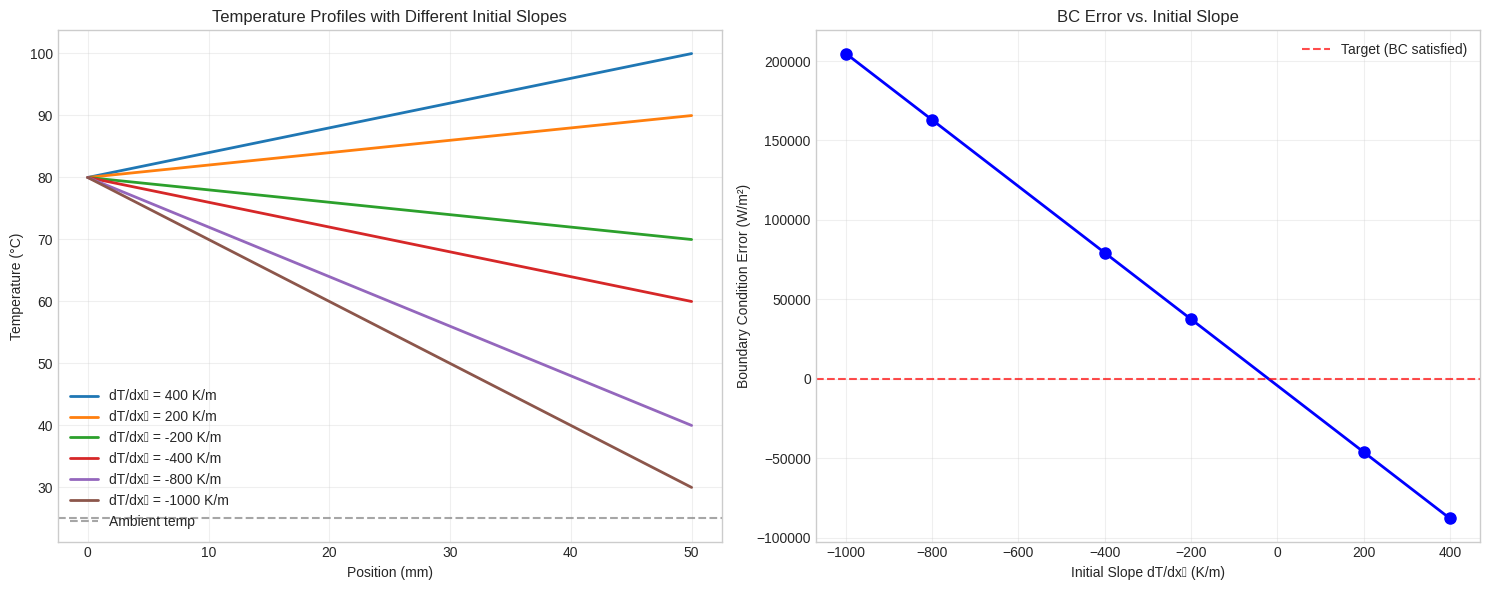


Observation: We need to find the initial slope that makes the BC error = 0
This is exactly what the shooting method does!


In [10]:
# Plot the different temperature profiles
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Temperature profiles
for sol in solutions:
    ax1.plot(sol['x']*1000, sol['T'],
             label=f"dT/dx₀ = {sol['slope']:.0f} K/m", linewidth=2)

ax1.axhline(T_amb, color='gray', linestyle='--', alpha=0.7, label='Ambient temp')
ax1.set_xlabel('Position (mm)')
ax1.set_ylabel('Temperature (°C)')
ax1.set_title('Temperature Profiles with Different Initial Slopes')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Boundary condition errors
slopes = [sol['slope'] for sol in solutions]
bc_errors = [sol['bc_error'] for sol in solutions]

ax2.plot(slopes, bc_errors, 'bo-', linewidth=2, markersize=8)
ax2.axhline(0, color='red', linestyle='--', alpha=0.7, label='Target (BC satisfied)')
ax2.set_xlabel('Initial Slope dT/dx₀ (K/m)')
ax2.set_ylabel('Boundary Condition Error (W/m²)')
ax2.set_title('BC Error vs. Initial Slope')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nObservation: We need to find the initial slope that makes the BC error = 0")
print("This is exactly what the shooting method does!")

## Task 3: Linear Shooting Method Implementation

For **linear** BVPs, we can use a very efficient approach:
1. Make two initial guesses for the unknown boundary condition
2. Solve both IVPs
3. Use **linear interpolation** to find the correct initial condition

This is much more efficient than iterative root-finding methods!

In [ ]:
def linear_shooting_method(guess1, guess2):
    """
    Solve the BVP using linear shooting method with two guesses.

    Args:
        guess1, guess2: Two initial guesses for dT/dx at x=0

    Returns:
        dict: Solution information including correct initial slope
    """
    x_span = (0, L)
    x_eval = np.linspace(0, L, 100)

    # Solve with first guess
    y0_1 = [T_base, guess1]
    sol1 = solve_ivp(heat_fin_ode, x_span, y0_1, t_eval=x_eval, method='RK45')
    T_tip_1 = sol1.y[0, -1]
    dT_dx_tip_1 = sol1.y[1, -1]
    bc_error_1 = convective_bc_error(T_tip_1, dT_dx_tip_1)

    # TODO: Solve with second guess
    # Follow the same pattern as above for guess2
    y0_2 = [T_base, guess2]
    # sol2 = solve_ivp(...)  # Complete this line
    # T_tip_2 = ...          # Extract tip temperature
    # dT_dx_tip_2 = ...      # Extract tip slope
    # bc_error_2 = ...       # Calculate BC error

    # TODO: Linear interpolation to find correct initial slope
    # We want bc_error = 0, so interpolate between the two guesses
    # Formula: slope_correct = guess1 + (guess2 - guess1) * (0 - bc_error_1) / (bc_error_2 - bc_error_1)
    # slope_correct = ...    # Complete this calculation

    # TODO: Solve with the correct initial slope
    # y0_correct = [T_base, slope_correct]
    # sol_correct = solve_ivp(...)  # Complete this line

    # TODO: Verify the boundary condition
    # T_tip_correct = sol_correct.y[0, -1]
    # dT_dx_tip_correct = sol_correct.y[1, -1]
    # bc_error_final = convective_bc_error(T_tip_correct, dT_dx_tip_correct)

    # NOTE: Uncomment the return statement below after completing the TODOs
    # return {
    #     'guess1': guess1,
    #     'guess2': guess2,
    #     'bc_error_1': bc_error_1,
    #     'bc_error_2': bc_error_2,
    #     'slope_correct': slope_correct,
    #     'x': sol_correct.t,
    #     'T': sol_correct.y[0],
    #     'dT_dx': sol_correct.y[1],
    #     'bc_error_final': bc_error_final,
    #     'T_tip': T_tip_correct
    # }

    # Temporary return for incomplete function
    return {'guess1': guess1, 'guess2': guess2, 'bc_error_1': bc_error_1}

# Test the shooting method (will work partially until students complete TODOs)
print("Testing linear shooting method...")
partial_result = linear_shooting_method(-400, -1000)
print(f"First guess: {partial_result['guess1']} K/m → BC error: {partial_result['bc_error_1']:.1f} W/m²")
print("\nComplete the TODO sections above to implement the full shooting method!")

## Task 4: Solution Analysis (Complete after Task 3)

Once you've completed the shooting method implementation, run this cell to analyze the results.

In [ ]:
# Create comprehensive plots of the solution
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Temperature profile
ax1.plot(result['x']*1000, result['T'], 'b-', linewidth=3, label='CPU Fin Temperature')
ax1.axhline(T_amb, color='gray', linestyle='--', alpha=0.7, label='Ambient Temperature')
ax1.axhline(T_base, color='red', linestyle='--', alpha=0.7, label='Base Temperature')
ax1.set_xlabel('Position (mm)')
ax1.set_ylabel('Temperature (°C)')
ax1.set_title('Temperature Distribution Along CPU Heat Sink Fin')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Temperature gradient
ax2.plot(result['x']*1000, result['dT_dx'], 'r-', linewidth=3)
ax2.set_xlabel('Position (mm)')
ax2.set_ylabel('Temperature Gradient (K/m)')
ax2.set_title('Temperature Gradient Along Fin')
ax2.grid(True, alpha=0.3)

# Heat flux distribution
heat_flux = -k * result['dT_dx']  # Heat flux = -k * dT/dx
ax3.plot(result['x']*1000, heat_flux/1000, 'g-', linewidth=3)  # Convert to kW/m²
ax3.set_xlabel('Position (mm)')
ax3.set_ylabel('Heat Flux (kW/m²)')
ax3.set_title('Heat Flux Distribution')
ax3.grid(True, alpha=0.3)

# Shooting method illustration
guesses = [result['guess1'], result['guess2']]
errors = [result['bc_error_1'], result['bc_error_2']]
ax4.plot(guesses, errors, 'bo-', markersize=10, linewidth=2, label='Initial guesses')
ax4.plot(result['slope_correct'], result['bc_error_final'], 'rs',
         markersize=12, label='Correct solution')
ax4.axhline(0, color='red', linestyle='--', alpha=0.7)
ax4.set_xlabel('Initial Slope (K/m)')
ax4.set_ylabel('BC Error (W/m²)')
ax4.set_title('Linear Interpolation in Shooting Method')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate and display key engineering metrics
max_temp = np.max(result['T'])
max_temp_idx = np.argmax(result['T'])
max_temp_location = result['x'][max_temp_idx] * 1000
heat_input = -k * result['dT_dx'][0]
heat_output = -k * result['dT_dx'][-1]

print("\n=== Engineering Analysis ===")
print(f"Maximum temperature: {max_temp:.1f}°C at {max_temp_location:.1f} mm")
print(f"Heat input at base: {heat_input/1000:.1f} kW/m²")
print(f"Heat output at tip: {heat_output/1000:.1f} kW/m²")
print(f"Temperature drop along fin: {T_base - result['T_tip']:.1f}°C")
print(f"Fin efficiency: {((result['T_tip'] - T_amb)/(T_base - T_amb))*100:.1f}%")

## Task 5: Introducing Nonlinear Effects - Radiation Heat Transfer

For high-temperature operation (gaming CPUs, server processors), **radiation** becomes significant alongside convection. This creates a **nonlinear** boundary value problem that cannot be solved with simple linear interpolation.

### Nonlinear Heat Equation with Radiation

$$\frac{d^2T}{dx^2} + \frac{q}{k} - \frac{\sigma \epsilon P}{kA}(T^4 - T_{amb}^4) = 0$$

**New terms:**
- $\sigma = 5.67 \times 10^{-8}$ W/m²·K⁴ (Stefan-Boltzmann constant)
- $\epsilon = 0.05$ (emissivity of polished aluminum)
- $P/A$ = perimeter-to-area ratio for rectangular fin
- **$T^4$ term makes this nonlinear!**

In [ ]:
# Additional parameters for radiation
sigma = 5.67e-8      # Stefan-Boltzmann constant (W/m²·K⁴)
epsilon = 0.05       # Emissivity of polished aluminum
fin_width = 0.002    # Fin thickness (m)
fin_height = 0.010   # Fin height (m)
P = 2 * (fin_width + fin_height)  # Perimeter (m)
A = fin_width * fin_height         # Cross-sectional area (m²)
P_over_A = P / A                   # Perimeter-to-area ratio (1/m)

# High-temperature scenario
T_base_hot = 150      # High-performance CPU base temperature (°C)
T_amb_K = T_amb + 273.15  # Ambient temperature in Kelvin

print("=== Nonlinear Radiation Model Parameters ===")
print(f"Fin dimensions: {fin_width*1000:.1f} mm × {fin_height*1000:.1f} mm")
print(f"Perimeter/Area ratio: {P_over_A:.1f} m⁻¹")
print(f"Emissivity: {epsilon}")
print(f"High-temp base: {T_base_hot}°C")
print(f"Radiation parameter: σε(P/A)/k = {sigma*epsilon*P_over_A/k:.2e} m⁻²K⁻³")

In [ ]:
def heat_fin_ode_nonlinear(x, y):
    """
    Nonlinear heat transfer ODE system with radiation.

    Args:
        x: Position along fin (m)
        y: State vector [T, dT/dx] where T is in Celsius

    Returns:
        dydt: Derivatives [dT/dx, d²T/dx²]
    """
    T_celsius, dT_dx = y[0], y[1]
    T_kelvin = T_celsius + 273.15  # Convert to Kelvin for radiation

    # Radiation heat loss term: σε(P/A)(T⁴ - T_amb⁴)
    radiation_term = sigma * epsilon * P_over_A * (T_kelvin**4 - T_amb_K**4)

    # Nonlinear ODE: d²T/dx² + q/k - (radiation term)/k = 0
    dT_dt = dT_dx                                    # dy1/dx = y2
    d2T_dx2 = -q_gen/k + radiation_term/k           # dy2/dx = -q/k + radiation/k

    return [dT_dt, d2T_dx2]

# Test the nonlinear ODE function
test_y_hot = [120, -500]  # Test state: T=120°C, dT/dx=-500 K/m
test_derivs_nonlinear = heat_fin_ode_nonlinear(0.01, test_y_hot)
print(f"Nonlinear ODE test:")
print(f"Temperature: {test_y_hot[0]}°C = {test_y_hot[0]+273.15}K")
print(f"dT/dx = {test_derivs_nonlinear[0]} K/m")
print(f"d²T/dx² = {test_derivs_nonlinear[1]} K/m² (includes radiation effects)")

# Compare radiation vs convection at high temperature
T_test = 120  # °C
T_test_K = T_test + 273.15
conv_loss = h * (T_test - T_amb)
rad_loss = sigma * epsilon * (T_test_K**4 - T_amb_K**4)
print(f"\nAt {T_test}°C:")
print(f"Convection loss: {conv_loss:.0f} W/m²")
print(f"Radiation loss: {rad_loss:.0f} W/m²")

## Task 6: Shooting Method with Root Finding

For nonlinear BVPs, we need to use iterative root-finding methods like `scipy.optimize.fsolve` instead of simple linear interpolation.

In [ ]:
from scipy.optimize import fsolve

# Modified boundary condition function for nonlinear case
def convective_bc_error_nonlinear(T_L, dT_dx_L):
    """
    Calculate the error in the convective boundary condition (nonlinear case).
    Same as before - the boundary condition itself is still linear.
    """
    actual_flux = -k * dT_dx_L
    required_flux = h * (T_L - T_amb)
    return actual_flux - required_flux

def shooting_function_nonlinear(initial_slope):
    """
    Shooting function for the nonlinear BVP.
    Returns the boundary condition error for a given initial slope.

    Args:
        initial_slope: Array containing the initial slope guess (fsolve passes arrays)

    Returns:
        float: Boundary condition error
    """
    x_span = (0, L)
    y0 = [T_base_hot, initial_slope[0]]  # fsolve passes array, extract first element

    # TODO: Solve the nonlinear ODE system
    # sol = solve_ivp(...)  # Use heat_fin_ode_nonlinear function

    # TODO: Check if solution was successful
    # if not sol.success:
    #     return 1e6  # Return large error if solution fails

    # TODO: Extract final values from the solution
    # T_tip = ...     # Temperature at the tip (final value)
    # dT_dx_tip = ... # Temperature gradient at the tip (final value)

    # TODO: Call function to calculate the boundary condition error

    # Return boundary condition error
    # Temporary return for incomplete function
    return 0

print("=== Solving Nonlinear BVP with Root Finding ===")
print("Using scipy.optimize.fsolve...")

# TODO: Set up initial guess for root finding
# initial_guess = [...]  # Starting guess for dT/dx at x=0 (try around -1500)

# TODO: Use fsolve to find the correct initial slope
# This is the key step - fsolve will iteratively adjust the initial slope
# until the boundary condition error is approximately zero
# correct_slope_array = fsolve(shooting_function_nonlinear, initial_guess)
# slope_final = correct_slope_array[0]  # Extract the scalar value

# TODO: Solve the complete problem with the correct slope
# x_span = (0, L)
# x_eval = np.linspace(0, L, 100)
# y0_final = [T_base_hot, slope_final]
# sol_final = solve_ivp(...)  # Solve with the correct initial slope

# TODO: Verify the solution by checking the boundary condition
# T_tip_final = sol_final.y[0, -1]
# dT_dx_tip_final = sol_final.y[1, -1]
# bc_error_final = convective_bc_error_nonlinear(T_tip_final, dT_dx_tip_final)

# TODO: Print the results
# print(f"Correct initial slope: {slope_final:.1f} K/m")
# print(f"Final BC error: {bc_error_final:.2e} W/m² (should be ≈ 0)")
# print(f"Tip temperature: {T_tip_final:.1f}°C")

print("Complete the TODO sections to implement nonlinear shooting method!")
print("Key insight: fsolve iteratively adjusts the initial slope until BC error ≈ 0")

## Task 7: Comparing Linear vs Nonlinear Solutions

Let's compare the linear (convection only) and nonlinear (convection + radiation) solutions.

In [ ]:
# This section will work after students complete previous tasks
print("=== Comparison: Linear vs Nonlinear Heat Transfer ===")

try:
    # Check if linear solution exists (from Task 3)
    if 'result' in globals() and 'slope_correct' in result:
        print("✅ Linear solution (convection only):")
        print(f"   Base temperature: {T_base}°C")
        print(f"   Tip temperature: {result['T_tip']:.1f}°C")
        print(f"   Initial slope: {result['slope_correct']:.1f} K/m")
        linear_available = True
    else:
        print("❌ Linear solution: Complete Task 3 first!")
        linear_available = False

    # Check if nonlinear solution exists (from Task 6)
    if 'sol_final' in globals() and 'T_tip_final' in globals():
        print("✅ Nonlinear solution (convection + radiation):")
        print(f"   Base temperature: {T_base_hot}°C")
        print(f"   Tip temperature: {T_tip_final:.1f}°C")
        print(f"   Initial slope: {slope_final:.1f} K/m")
        nonlinear_available = True
    else:
        print("❌ Nonlinear solution: Complete Task 6 first!")
        nonlinear_available = False

    # Only proceed with comparison if both solutions exist
    if linear_available and nonlinear_available:

        # TODO: Calculate the temperature difference
        # Note: Be careful - different base temperatures!
        # temp_difference = ...  # How much cooler is the nonlinear solution?

        print(f"\n🔍 Key Differences:")
        print(f"   Higher base temperature: {T_base_hot - T_base}°C increase")
        # print(f"   Radiation cooling effect: {temp_difference:.1f}°C reduction")
        print(f"   Different physics: T⁴ radiation vs linear convection")

        # Create comparison plots
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

        # TODO: Plot temperature profiles comparison
        # ax1.plot(result['x']*1000, result['T'], 'b-', linewidth=3, label='Linear (convection only)')
        # ax1.plot(sol_final.t*1000, sol_final.y[0], 'r-', linewidth=3, label='Nonlinear (conv + radiation)')
        # ax1.axhline(T_amb, color='gray', linestyle='--', alpha=0.7, label='Ambient')
        # ax1.set_xlabel('Position (mm)')
        # ax1.set_ylabel('Temperature (°C)')
        # ax1.set_title('Temperature Profiles: Linear vs Nonlinear')
        # ax1.legend()
        # ax1.grid(True, alpha=0.3)

        # TODO: Plot heat flux comparison
        # heat_flux_linear = -k * result['dT_dx']
        # heat_flux_nonlinear = -k * sol_final.y[1]
        # ax2.plot(result['x']*1000, heat_flux_linear/1000, 'b-', linewidth=2, label='Linear case')
        # ax2.plot(sol_final.t*1000, heat_flux_nonlinear/1000, 'r-', linewidth=2, label='Nonlinear case')
        # ax2.set_xlabel('Position (mm)')
        # ax2.set_ylabel('Heat Flux (kW/m²)')
        # ax2.set_title('Heat Flux Distribution')
        # ax2.legend()
        # ax2.grid(True, alpha=0.3)

        # TODO: Show radiation vs convection heat loss (nonlinear case only)
        # T_nonlinear_K = sol_final.y[0] + 273.15
        # conv_loss_dist = h * (sol_final.y[0] - T_amb)
        # rad_loss_dist = sigma * epsilon * (T_nonlinear_K**4 - T_amb_K**4)
        #
        # ax3.plot(sol_final.t*1000, conv_loss_dist, 'b-', linewidth=2, label='Convection loss')
        # ax3.plot(sol_final.t*1000, rad_loss_dist, 'r-', linewidth=2, label='Radiation loss')
        # ax3.set_xlabel('Position (mm)')
        # ax3.set_ylabel('Heat Loss (W/m²)')
        # ax3.set_title('Heat Loss Mechanisms (Nonlinear Case)')
        # ax3.legend()
        # ax3.grid(True, alpha=0.3)

        # TODO: Method comparison illustration
        # Show linear interpolation vs root-finding approach
        # ax4.text(0.1, 0.8, 'Linear BVP Method:', transform=ax4.transAxes, fontsize=12, weight='bold')
        # ax4.text(0.1, 0.7, '• 2 initial guesses', transform=ax4.transAxes, fontsize=10)
        # ax4.text(0.1, 0.6, '• Linear interpolation', transform=ax4.transAxes, fontsize=10)
        # ax4.text(0.1, 0.5, '• Exact solution', transform=ax4.transAxes, fontsize=10, color='blue')
        #
        # ax4.text(0.1, 0.3, 'Nonlinear BVP Method:', transform=ax4.transAxes, fontsize=12, weight='bold')
        # ax4.text(0.1, 0.2, '• Root-finding (fsolve)', transform=ax4.transAxes, fontsize=10)
        # ax4.text(0.1, 0.1, '• Iterative solution', transform=ax4.transAxes, fontsize=10)
        # ax4.text(0.1, 0.0, '• Handles T⁴ nonlinearity', transform=ax4.transAxes, fontsize=10, color='red')
        # ax4.set_xlim(0, 1)
        # ax4.set_ylim(0, 1)
        # ax4.set_title('Solution Method Comparison')
        # ax4.axis('off')

        # plt.tight_layout()
        # plt.show()

        print("\n🎯 Complete the TODO sections to see the comparison plots!")

    else:
        print("\nComplete both linear (Task 3) and nonlinear (Task 6) solutions to see comparison!")

except Exception as e:
    print(f"Error in comparison: {e}")
    print("Make sure both Task 3 and Task 6 are completed!")

## Discussion Questions

1. **Why can't we solve boundary value problems directly like initial value problems?**

2. **When does linear interpolation work vs. when do we need root-finding methods?**

3. **How does the shooting method 'shoot' from one boundary to satisfy the condition at the other boundary?**

4. **Explain in your own words how the nonlinear shooting method is formulated as a roots problem. What is the residual that we ar eminimizing here?**


## Key Takeaways

### Mathematical Concepts
- **Linear BVPs**: Use efficient linear interpolation (2 shots)
- **Nonlinear BVPs**: Require iterative root-finding methods
- **scipy tools**: `solve_ivp` for ODEs, `fsolve` for root-finding
- **Method selection**: Problem linearity determines approach
